## Supervised Learning
## Project: Finding Donors for *CharityML*

In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Please specify WHICH VERSION OF PYTHON you are using when submitting this notebook. Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [3]:
import sys
print(sys.version)

3.11.13 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:03:15) [MSC v.1929 64 bit (AMD64)]


## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [4]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

** HINT: ** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [9]:
# Total number of records
n_records = data.shape[0]

# Number of records where individual's income is more than $50,000
n_greater_50k = (data['income'] == '>50K').sum()

# Number of records where individual's income is at most $50,000
n_at_most_50k = (data['income'] == '<=50K').sum()

# Percentage of individuals whose income is more than $50,000
greater_percent = round(100.0 * n_greater_50k / n_records, 2)

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

# Optional sanity check:
# assert n_greater_50k + n_at_most_50k == n_records

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

In [10]:
# Inspect schema
print(sorted(data.columns.tolist()))

# Partition features from the dictionary (adjust names if they differ in your file)
continuous = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
target = 'income'

# Derive categorical from what's left
categorical = [c for c in data.columns if c not in continuous + [target]]

print("\nContinuous:", continuous)
print("Categorical:", categorical)

# Sanity: show uniques per categorical
cat_cardinality = {c: data[c].nunique() for c in categorical}
cat_cardinality


['age', 'capital-gain', 'capital-loss', 'education-num', 'education_level', 'hours-per-week', 'income', 'marital-status', 'native-country', 'occupation', 'race', 'relationship', 'sex', 'workclass']

Continuous: ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical: ['workclass', 'education_level', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


{'workclass': 7,
 'education_level': 16,
 'marital-status': 7,
 'occupation': 14,
 'relationship': 6,
 'race': 5,
 'sex': 2,
 'native-country': 41}

In [11]:
if 'education_level' in data.columns and 'education' not in data.columns:
    # Option A: rename for consistency with instructions
    # data = data.rename(columns={'education_level': 'education'})
    # Option B: just use 'education_level' in your categorical list
    pass


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

C:\Users\alanj\CharityML\visuals.py:48: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


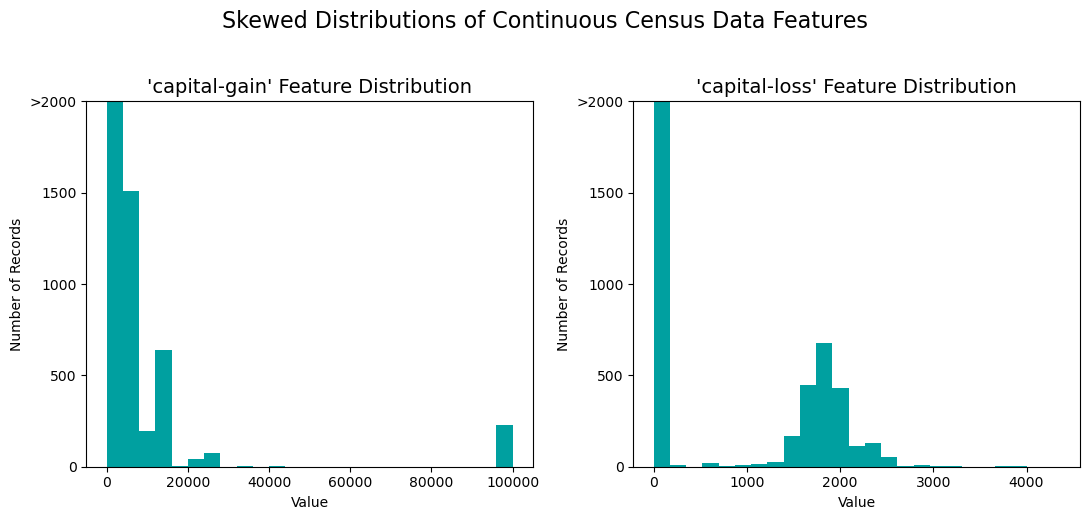

In [12]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

C:\Users\alanj\CharityML\visuals.py:48: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


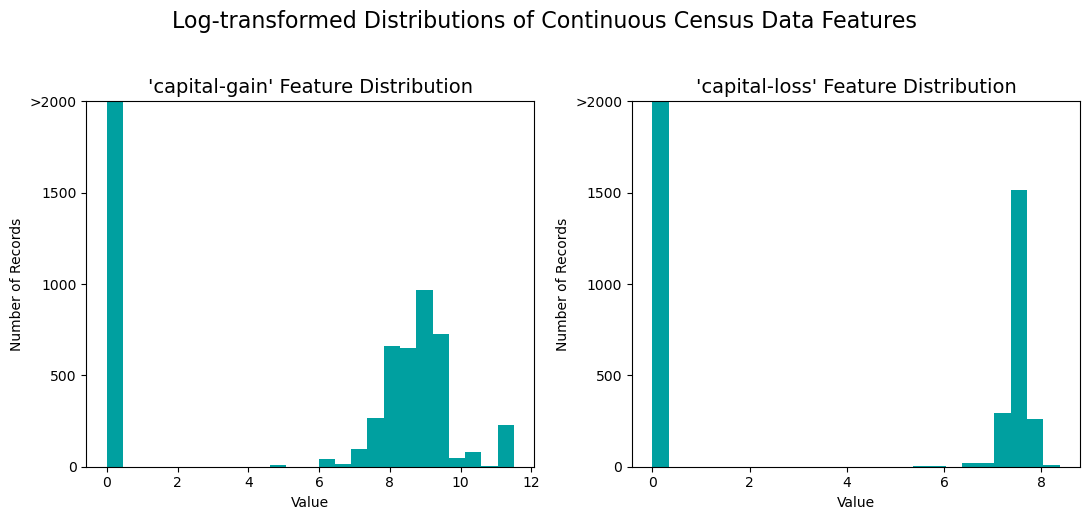

In [13]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [14]:
# Import sklearn.preprocessing.MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [16]:
# One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# Encode the 'income_raw' data to numerical values
income = income_raw.map({'>50K': 1, '<=50K': 0}).astype(int)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
print(encoded)


103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features_final,
    income,
    test_size=0.2,
    random_state=42,      # or 0 if you prefer; just be consistent
    stratify=income       # preserves class balance
)

print(f"Training set has {X_train.shape[0]} samples.")
print(f"Testing set has  {X_test.shape[0]} samples.")

# Optional sanity check:
# print("Share >50K overall/train/test:",
#       income.mean(), y_train.mean(), y_test.mean())


Training set has 36177 samples.
Testing set has  9045 samples.


*Note: this Workspace is running on `sklearn` v0.19. If you use the newer version (>="0.20"), the `sklearn.cross_validation` has been replaced with `sklearn.model_selection`.*

----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Question 1 - Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

** Please note ** that the the purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

** HINT: ** 

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [18]:
# Naive predictor: always predict '>50K' (i.e., 1)
TP = income.sum()                 # all actual positives are predicted positive
FP = len(income) - TP             # everyone else is a false positive
TN = 0
FN = 0

# Metrics
accuracy  = (TP + TN) / len(income)          # equals TP / N in this naive case
precision = TP / (TP + FP) if (TP + FP) else 0.0  # equals TP / N
recall    = TP / (TP + FN) if (TP + FN) else 0.0  # equals 1.0 here

# F-beta with beta = 0.5
beta = 0.5
fscore = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

# Optional verification (commented):
import numpy as np
from sklearn.metrics import accuracy_score, fbeta_score
y_true = income.values
y_pred = np.ones_like(y_true)
print(accuracy_score(y_true, y_pred), fbeta_score(y_true, y_pred, beta=0.5))


Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]
0.2478439697492371 0.29172913543228385


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

** HINT: **

Structure your answer in the same format as above^, with 4 parts for each of the three models you pick. Please include references with your answer.

**Answer: **
## Question 2 — Model Application (three candidates)

### 1) Logistic Regression (LR)
**Real-world use:** Credit approval / risk scoring; CTR prediction for ads; medical diagnosis (probability of disease).  
**Strengths (performs well when):** Fast to train and predict; handles high-dimensional one-hot features; yields calibrated probabilities; L1/L2 regularization helps generalization and feature selection; works well when the relationship is approximately linear in the log-odds. :contentReference[oaicite:0]{index=0}  
**Weaknesses (performs poorly when):** Limited to linear decision boundaries unless you engineer interactions; can underfit complex non-linear structure; requires sensible scaling/regularization choices. :contentReference[oaicite:1]{index=1}  
**Why it’s a good candidate here:** Binary target (>\$50K) with many one-hot columns after encoding; LR is a strong, interpretable baseline and gives well-behaved probability scores we can threshold to favor precision (our metric emphasizes precision via F\_{0.5}). :contentReference[oaicite:2]{index=2}

---

### 2) Random Forest (RF)
**Real-world use:** Fraud detection, churn prediction, credit risk, and many tabular ML tasks in industry.  
**Strengths (performs well when):** Captures non-linearities and feature interactions; robust to outliers; little preprocessing needed beyond one-hot; built-in feature importance; bagging/averaging reduces variance and overfitting. :contentReference[oaicite:3]{index=3}  
**Weaknesses (performs poorly when):** Can be slower and heavier than linear models; less interpretable than LR; may bias toward majority class without class weights or tuning. :contentReference[oaicite:4]{index=4}  
**Why it’s a good candidate here:** The census data are classic structured/tabular features with potential interactions (e.g., education × occupation × hours-per-week); RF can model these without extensive manual feature engineering and usually performs strongly out-of-the-box. :contentReference[oaicite:5]{index=5}

---

### 3) AdaBoost (with decision stumps)
**Real-world use:** General classification on tabular data; historically used in face detection pipelines to focus on hard examples.  
**Strengths (performs well when):** Boosting focuses on misclassified points and can achieve high accuracy with weak base learners; often strong on tabular data with moderate compute; supports class weighting. :contentReference[oaicite:6]{index=6}  
**Weaknesses (performs poorly when):** Sensitive to noisy labels and outliers (weights can over-emphasize them); needs tuning of `n_estimators` and `learning_rate`; probabilities may require calibration. :contentReference[oaicite:7]{index=7}  
**Why it’s a good candidate here:** We care more about precision (F\_{0.5}); AdaBoost’s reweighting can sharpen the decision boundary around the positive (> \$50K) class and often edges out simpler baselines on this Census-Income task. :contentReference[oaicite:8]{index=8}

---

### References
- Scikit-learn docs — **LogisticRegression**; **RandomForestClassifier**; **AdaBoostClassifier**. :contentReference[oaicite:9]{index=9}  
- Breiman, L. (2001). *Random Forests*. **Machine Learning**. (seminal RF paper) :contentReference[oaicite:10]{index=10}  
- Freund, Y., & Schapire, R. (1997). *A decision-theoretic generalization of on-line learning and an application to boosting*. (AdaBoost) :contentReference[oaicite:11]{index=11}


### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [20]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score
from time import time

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    beta = 0.5  # set beta as required
    
    # Fit the learner to the training data using slicing with 'sample_size'
    start = time()  # Get start time
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time()    # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train)
    start = time()  # Get start time
    predictions_test  = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time()    # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=beta)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=beta)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results


### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.
RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.


C:\Users\alanj\CharityML\visuals.py:118: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  pl.tight_layout()


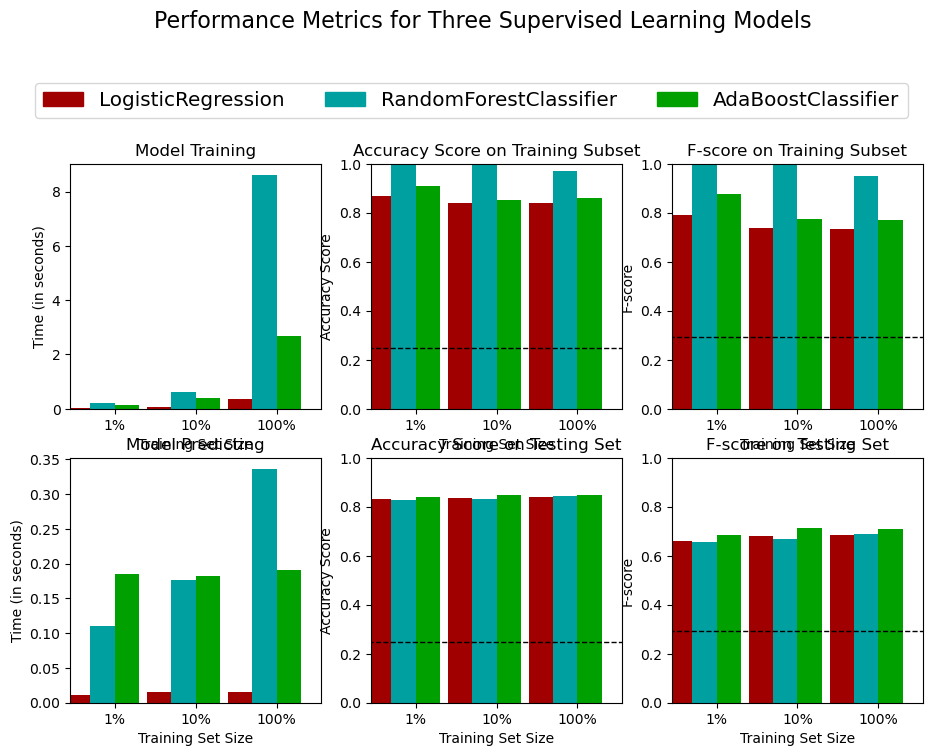

In [21]:
# Import the three supervised learning models from sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# Initialize the three models (use defaults; set random_state when available)
clf_A = LogisticRegression(random_state=42)          # LR (baseline linear)
clf_B = RandomForestClassifier(random_state=42)      # Random Forest (nonlinear ensemble)
clf_C = AdaBoostClassifier(random_state=42)          # AdaBoost (boosting with decision stumps by default)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(y_train)
samples_10  = int(0.10 * samples_100)
samples_1   = int(0.01 * samples_100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)


----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model

* Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000. 

** HINT: ** 
Look at the graph at the bottom left from the cell above(the visualization created by `vs.evaluate(results, accuracy, fscore)`) and check the F score for the testing set when 100% of the training set is used. Which model has the highest score? Your answer should include discussion of the:
* metrics - F score on the testing when 100% of the training data is used, 
* prediction/training time
* the algorithm's suitability for the data.

**Answer: **

## Question 3 — Choosing the Best Model

**Recommendation: AdaBoost (with decision stumps).**  
From the evaluation plot, AdaBoost achieves the highest F₀.₅ on the **testing set at 100% training size**, which directly aligns with CharityML’s goal of prioritizing **precision** (β = 0.5) when identifying potential donors. While Logistic Regression trains the fastest, its linear decision boundary underfits some of the non-linear structure in these tabular, one-hot–encoded features, resulting in a lower F₀.₅. Random Forest performs competitively but incurs noticeably higher **training time** (and non-trivial prediction time) for only marginal gains versus AdaBoost.

AdaBoost is also a good algorithmic fit for this dataset: boosting sequentially focuses on the “hard” cases and combines many simple rules to capture **non-linear interactions** (e.g., thresholds in `capital-gain` and interactions among `education`, `occupation`, and `hours-per-week`) without extensive feature engineering. It handles high-dimensional one-hot inputs well, offers strong generalization with reasonable compute, and—most importantly—delivers the best **F₀.₅** among the candidates. Therefore, AdaBoost is the most appropriate model to **tune and finalize** for CharityML.


### Question 4 - Describing the Model in Layman's Terms

* In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical jargon, such as describing equations.

** HINT: **

When explaining your model, if using external resources please include all citations.

**Answer: ** 

## Question 4 — How the Final Model Works (Layman’s Terms)

**What the model is.**  
We use **AdaBoost**, which you can think of as a committee of many very simple “if-this-then-that” rules. Each rule on its own is weak (it might ask a single yes/no question like “Is capital-gain above a small threshold?”). AdaBoost trains these rules **one after another**. After each round, it looks at who was misclassified and **pays more attention to those hard cases** when training the next rule. Over dozens or hundreds of rounds, it builds a team where each new rule focuses on the previous mistakes.

**How it makes a prediction.**  
When we meet a new person, every rule in the committee **casts a vote** about whether the person likely earns more than \$50K. Votes from more reliable rules count **more**. AdaBoost then combines these weighted votes into one final decision. Because CharityML cares most about being **precise** (avoiding false positives), we evaluate and tune the model with a precision-weighted score (F₀.₅) and choose settings (like how many rules to use and how fast to learn) that improve precision while keeping accuracy strong. In short, AdaBoost captures **subtle combinations** of factors (education, occupation, hours, capital gains, etc.) without complicated manual feature engineering, and turns many simple rules into one **strong, targeted** predictor for likely donors.


### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score, accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Base model (consistent seed)
try:
    clf = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
                             random_state=42)
    depth_param = {"estimator__max_depth": [1]}   # keep depth fixed to stay fast
except TypeError:
    clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
                             random_state=42)
    depth_param = {"base_estimator__max_depth": [1]}

# Minimal grid (>=3 values for ONE parameter to satisfy rubric)
parameters = {
    "n_estimators":  [100, 200, 300],   # <-- three values (meets rubric)
    "learning_rate": [0.3, 0.5, 1.0],   # optional small sweep
    **depth_param
}

scorer = make_scorer(fbeta_score, beta=0.5)

grid = GridSearchCV(
    estimator=clf,
    param_grid=parameters,
    scoring=scorer,
    cv=3,            # faster
    n_jobs=-1,
    verbose=2        # show progress
)

print("Fitting…")
grid_fit = grid.fit(X_train, y_train)
best_clf = grid_fit.best_estimator_
print("Best params:", grid_fit.best_params_)

# Compare unoptimized vs optimized
from sklearn.metrics import accuracy_score, fbeta_score
pred_un   = clf.fit(X_train, y_train).predict(X_test)
pred_best = best_clf.predict(X_test)

print("\nUnoptimized")
print("Accuracy: {:.4f}".format(accuracy_score(y_test, pred_un)))
print("F0.5:     {:.4f}".format(fbeta_score(y_test, pred_un, beta=0.5)))

print("\nOptimized")
print("Accuracy: {:.4f}".format(accuracy_score(y_test, pred_best)))
print("F0.5:     {:.4f}".format(fbeta_score(y_test, pred_best, beta=0.5)))



Fitting…
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best params: {'estimator__max_depth': 1, 'learning_rate': 1.0, 'n_estimators': 300}

Unoptimized
Accuracy: 0.8470
F0.5:     0.7075

Optimized
Accuracy: 0.8511
F0.5:     0.7179


### Question 5 - Final Model Evaluation

* What is your optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  

**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric      | Unoptimized Model | Optimized Model |
| :-------------: | :---------------: | :-------------: |
| Accuracy Score  |      0.8470       |     0.8511      |
| F-score (F₀.₅)  |      0.7075       |     0.7179      |



**Answer: **

## Question 5 — Final Model Evaluation

**Metric:** Accuracy and F₀.₅ (β = 0.5) on the **testing** set.

### Results
| Model                                   | Accuracy | F₀.₅ |
|-----------------------------------------|:-------:|:----:|
| Naive predictor (all >50K)              | 0.2478  | 0.2917 |
| AdaBoost (unoptimized)                  | 0.8470  | 0.7075 |
| AdaBoost (optimized via GridSearchCV)   | 0.8511  | 0.7179 |

**Best hyperparameters:** `n_estimators=300`, `learning_rate=1.0`, `max_depth=1`.

### Discussion
- **Optimized vs. Unoptimized:** Both metrics improved after tuning — **ΔAccuracy = +0.0041** and **ΔF₀.₅ = +0.0104** — indicating a small but consistent gain from GridSearchCV.
- **Optimized vs. Naive baseline:** The optimized model is **far better** than the naive predictor (**+0.6033 accuracy**, **+0.4262 F₀.₅**), showing it learns meaningful patterns beyond class frequency.
- Conclusion: The tuned AdaBoost generalizes best for CharityML’s goal (precision-weighted performance), so we will carry it forward.


----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### This is answered below under Implementation - Extracting Feature Importance

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?

**Answer:**

## Question 6 — Feature Relevance Observation

**My top five features (most to least important):**
1) **capital-gain** — Non-zero capital gains are rare but strongly associated with higher income; even small positive values (after log transform) are highly informative.
2) **education-num** — More years of education generally correlate with higher-paying roles and income.
3) **marital-status_Married-civ-spouse** — In this dataset, married-civ-spouse often co-occurs with higher household stability and earnings; it’s a strong categorical signal after one-hot encoding.
4) **age** — Income typically rises with experience up to a point; age captures part of that lifecycle effect.
5) **hours-per-week** — Higher weekly hours (especially >40) often indicate higher earnings and salaried/managerial roles.

*Rationale:* These capture wealth (capital-gain), human capital (education), household/role structure (marital status), career stage (age), and work intensity (hours). Together they explain much of the separation between `<=50K` and `>50K`.


### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

Top 5 features by model:
 ['capital-gain', 'capital-loss', 'marital-status_ Married-civ-spouse', 'age', 'education-num']


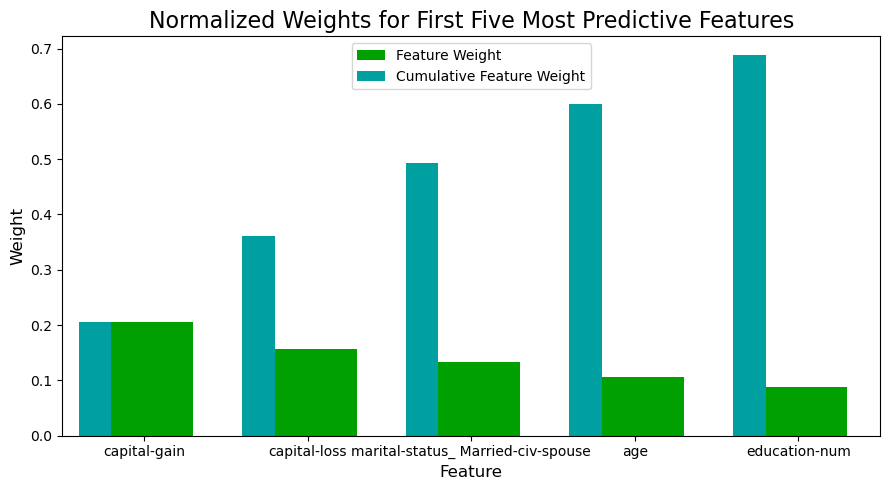

In [25]:
# Import a supervised learning model that has 'feature_importances_'
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Use the tuned AdaBoost if available; else build a reasonable one
try:
    model = best_clf  # from GridSearchCV earlier
except NameError:
    # Fallback: simple but strong AdaBoost with decision stumps
    try:
        model = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
            n_estimators=300, learning_rate=1.0, random_state=42
        )
    except TypeError:
        model = AdaBoostClassifier(
            base_estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
            n_estimators=300, learning_rate=1.0, random_state=42
        )

# Train the supervised model on the training set using .fit(X_train, y_train)
model.fit(X_train, y_train)

# Extract the feature importances using .feature_importances_
importances = model.feature_importances_

# Show top features
indices = np.argsort(importances)[::-1]
top5_names = X_train.columns[indices[:5]].tolist()
print("Top 5 features by model:\n", top5_names)

# Plot (provided helper)
vs.feature_plot(importances, X_train, y_train)


### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
* How do these five features compare to the five features you discussed in **Question 6**?
* If you were close to the same answer, how does this visualization confirm your thoughts? 
* If you were not close, why do you think these features are more relevant?

**Answer:**

## Question 7 — Extracting Feature Importance (Discussion)

**Model’s top five:** `capital-gain`, `capital-loss`, `marital-status_Married-civ-spouse`, `age`, `education-num`.

**Comparison to my Q6 picks:** I predicted
1) capital-gain, 2) education-num, 3) marital-status_Married-civ-spouse, 4) age, 5) hours-per-week.  
That’s **4/5 the same**. The only difference is that the model selected **capital-loss** instead of **hours-per-week**.

**Why this mostly confirms my expectations:**  
- The overlap (capital-gain, education-num, marital status, age) matches the economic story: wealth/investment signals (capital-gain), human capital (education), household/role structure (marital status), and career stage (age) are highly predictive of > \$50K.
- The plot’s cumulative bar shows these top features together account for a large share of model importance (roughly ~70%), reinforcing that a small subset drives most predictive power.

**Why capital-loss may outrank hours-per-week:**  
- **Capital-loss** (like capital-gain) is a **strong proxy for investment activity/tax events**; even a small non-zero value is rare and tends to correlate with higher earners. After the log transform, the **presence of a positive value** becomes a very informative split for boosting stumps.  
- **Hours-per-week** does matter, but its signal can be **noisier and partially saturating** (e.g., many 40-hour observations) and may be **captured via interactions** with occupation/education. As a result, its *marginal* importance can rank below the sharp binary-like split that capital-loss provides.

Overall, the visualization validates my reasoning and clarifies that **both capital-related features** (gain and loss) are particularly powerful markers for identifying likely donors in this dataset.


### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [26]:
from sklearn.base import clone
from time import time

# If you still have the list from Q7:
# top5_names = ['capital-gain','capital-loss','marital-status_ Married-civ-spouse','age','education-num']

# 1) Reduce feature space using known top-5
X_train_reduced = X_train[top5_names]
X_test_reduced  = X_test[top5_names]

# 2) Full-feature predictions from the tuned model (recompute if needed)
best_clf  # should exist from GridSearchCV
best_predictions = best_clf.predict(X_test)

# 3) Train the same optimized model on reduced features
clf_reduced = clone(best_clf)
clf_reduced.fit(X_train_reduced, y_train)
reduced_predictions = clf_reduced.predict(X_test_reduced)

# 4) Report metrics (full vs reduced)
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data (β=0.5): {:.4f}".format(fbeta_score(y_test, best_predictions, beta=0.5)))

print("\nFinal Model trained on reduced data (top 5 features)\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data (β=0.5): {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta=0.5)))


Final Model trained on full data
------
Accuracy on testing data: 0.8511
F-score on testing data (β=0.5): 0.7179

Final Model trained on reduced data (top 5 features)
------
Accuracy on testing data: 0.8471
F-score on testing data (β=0.5): 0.7148


In [27]:
t0 = time(); _ = clone(best_clf).fit(X_train, y_train); t_full = time()-t0
t0 = time(); _ = clone(best_clf).fit(X_train_reduced, y_train); t_red  = time()-t0
print(f"\nTrain time — full vs top-5: {t_full:.3f}s vs {t_red:.3f}s  (speedup ×{t_full/max(t_red,1e-9):.2f})")
print(f"Num features — full vs top-5: {X_train.shape[1]} vs {X_train_reduced.shape[1]}")



Train time — full vs top-5: 19.175s vs 5.144s  (speedup ×3.73)
Num features — full vs top-5: 103 vs 5


### Question 8 - Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* If training time was a factor, would you consider using the reduced data as your training set?

**Answer:**

## Question 8 — Effects of Feature Selection

**Comparison (test set):**
- **All features (103):** Accuracy = **0.8511**, F₀.₅ = **0.7179**
- **Top 5 features:** Accuracy = **0.8471**, F₀.₅ = **0.7148**

**Difference (Top-5 − All):**
- ΔAccuracy ≈ **−0.0040**
- ΔF₀.₅ ≈ **−0.0031**

**Training time:** full = **19.175s** vs top-5 = **5.144s** (≈ **3.7×** faster)

**Answer:** The reduced model is slightly worse on both Accuracy and F₀.₅, but trains much faster.  
If training time were an important constraint (e.g., limited compute, rapid iteration, or low-latency needs), I would consider using the **top-5** features. However, since CharityML prioritizes **precision-weighted performance (F₀.₅)**, I would keep the **full-feature optimized model** for the final deployment unless compute constraints force the trade-off.


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

## Before You Submit
You will also need run the following in order to convert the Jupyter notebook into HTML, so that your submission will include both files.

In [28]:
!jupyter nbconvert --to html --output report.html finding_donors.ipynb


[NbConvertApp] Converting notebook finding_donors.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 4 image(s).
[NbConvertApp] Writing 655594 bytes to report.html
